In [25]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint


In [2]:
# Fetching the data from API
# Vienna, timeseries, 1h-1km, all parameters, 2018-2023 (01-01)

url = "https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2018-01-01T00%3A00&end=2024-01-01T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2018_2023_0101"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print("Fetched data successfully")
else:
    print("Failed to retrieve data", response.status_code)


Fetched data successfully


In [7]:
# Processing the data
data_list = []
for feature in data['features']:
    location = feature['geometry']['coordinates']
    for i, timestamp in enumerate(data['timestamps']):
        record = {
            'time': pd.to_datetime(timestamp),
            'longitude': location[0],
            'latitude': location[1],
            'RR': feature['properties']['parameters']['RR']['data'][i],
            'T2M': feature['properties']['parameters']['T2M']['data'][i],
            'RH2M': feature['properties']['parameters']['RH2M']['data'][i],
            'TD2M': feature['properties']['parameters']['TD2M']['data'][i],
            'GL': feature['properties']['parameters']['GL']['data'][i],
            'UU': feature['properties']['parameters']['UU']['data'][i],
            'VV': feature['properties']['parameters']['VV']['data'][i],
            'P0': feature['properties']['parameters']['P0']['data'][i]
        }
        data_list.append(record)

df = pd.DataFrame(data_list)

In [36]:
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,temp_humidity_interaction,wind_rain_interaction,RR_lag1,T2M_lag1,hour_sin,hour_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1.0,1.0,0.00000,0.327015,0.956816,0.456202,0.0,0.343777,0.548272,0.377752,...,0.429764,0.000000,0.0,0.336780,0.629410,0.982963,0.50,1.000000,0.500000,1.000000
1,1.0,1.0,0.00000,0.312273,0.993356,0.448216,0.0,0.446475,0.522358,0.376098,...,0.409415,0.000000,0.0,0.327015,0.750000,0.933013,0.50,1.000000,0.500000,1.000000
2,1.0,1.0,0.00000,0.314379,1.000000,0.452957,0.0,0.461271,0.518293,0.374847,...,0.412554,0.000000,0.0,0.312273,0.853553,0.853553,0.50,1.000000,0.500000,1.000000
3,1.0,1.0,0.00000,0.313996,1.000000,0.452458,0.0,0.467798,0.529472,0.373324,...,0.411995,0.000000,0.0,0.314379,0.933013,0.750000,0.50,1.000000,0.500000,1.000000
4,1.0,1.0,0.00000,0.316102,1.000000,0.455203,0.0,0.453438,0.479675,0.375194,...,0.415069,0.000000,0.0,0.313996,0.982963,0.629410,0.50,1.000000,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105104,0.0,0.0,0.00000,0.347884,0.841810,0.445221,0.0,0.442994,0.517276,0.372732,...,0.452734,0.000000,0.0,0.333716,0.066987,0.750000,0.25,0.933013,0.439732,0.996354
105105,0.0,0.0,0.00000,0.352671,0.804238,0.437984,0.0,0.481723,0.532520,0.372102,...,0.456455,0.000000,0.0,0.347884,0.146447,0.853553,0.25,0.933013,0.439732,0.996354
105106,0.0,0.0,0.00000,0.339843,0.820962,0.427502,0.0,0.443429,0.516260,0.387165,...,0.441683,0.000000,0.0,0.352671,0.250000,0.933013,0.25,0.933013,0.439732,0.996354
105107,0.0,0.0,0.00000,0.390197,0.753837,0.466933,0.0,0.610096,0.591972,0.373615,...,0.496368,0.000000,0.0,0.339843,0.370590,0.982963,0.25,0.933013,0.439732,0.996354


In [9]:

# Ensure all data are numeric and drop non-numeric
df.dropna(inplace=True)  # Drop rows with NaN values first

# feature selection
df['hour'] = df['time'].dt.hour
df['week_of_year'] = df['time'].dt.isocalendar().week
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year

df['wind_speed'] = np.sqrt(df['UU']**2 + df['VV']**2)
df['wind_direction'] = np.arctan2(df['VV'], df['UU']) * 180 / np.pi  # Converts wind vector to direction

df['temp_humidity_interaction'] = df['T2M'] * df['RH2M']
df['wind_rain_interaction'] = df['wind_speed'] * df['RR']

df['RR_lag1'] = df['RR'].shift(1)
df['T2M_lag1'] = df['T2M'].shift(1)

# cyclical
df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
df['month_sin'] = np.sin((df['month'] - 1) * (2 * np.pi / 12))
df['month_cos'] = np.cos((df['month'] - 1) * (2 * np.pi / 12))
df['week_of_year_sin'] = np.sin((df['week_of_year'] - 1) * (2. * np.pi / 52))
df['week_of_year_cos'] = np.cos((df['week_of_year'] - 1) * (2. * np.pi / 52))

df.drop(['time'], axis=1, inplace=True)
df = df.select_dtypes(include=[np.number])

df.dropna(inplace=True)

df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,temp_humidity_interaction,wind_rain_interaction,RR_lag1,T2M_lag1,hour_sin,hour_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,...,112.5891,0.00000,0.0,1.68,0.258819,0.965926,0.0,1.000000,0.0,1.0
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,...,39.7680,0.00000,0.0,1.17,0.500000,0.866025,0.0,1.000000,0.0,1.0
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,...,51.0000,0.00000,0.0,0.40,0.707107,0.707107,0.0,1.000000,0.0,1.0
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,...,49.0000,0.00000,0.0,0.51,0.866025,0.500000,0.0,1.000000,0.0,1.0
5,16.638773,48.334339,0.000,0.60,100.00,0.60,0.0,0.43,-0.55,100951.46,...,60.0000,0.00000,0.0,0.49,0.965926,0.258819,0.0,1.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,...,194.7894,0.00000,0.0,1.52,-0.866025,0.500000,-0.5,0.866025,-0.120537,0.992709
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,...,208.1041,0.00000,0.0,2.26,-0.707107,0.707107,-0.5,0.866025,-0.120537,0.992709
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,...,155.2408,0.00000,0.0,2.51,-0.500000,0.866025,-0.5,0.866025,-0.120537,0.992709
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,...,350.9397,0.00000,0.0,1.84,-0.258819,0.965926,-0.5,0.866025,-0.120537,0.992709


In [10]:
# Scaling features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

# Create training and testing sets
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

In [20]:
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,temp_humidity_interaction,wind_rain_interaction,RR_lag1,T2M_lag1,hour_sin,hour_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1.0,1.0,0.00000,0.327015,0.956816,0.456202,0.0,0.343777,0.548272,0.377752,...,0.429764,0.000000,0.0,0.336780,0.629410,0.982963,0.50,1.000000,0.500000,1.000000
1,1.0,1.0,0.00000,0.312273,0.993356,0.448216,0.0,0.446475,0.522358,0.376098,...,0.409415,0.000000,0.0,0.327015,0.750000,0.933013,0.50,1.000000,0.500000,1.000000
2,1.0,1.0,0.00000,0.314379,1.000000,0.452957,0.0,0.461271,0.518293,0.374847,...,0.412554,0.000000,0.0,0.312273,0.853553,0.853553,0.50,1.000000,0.500000,1.000000
3,1.0,1.0,0.00000,0.313996,1.000000,0.452458,0.0,0.467798,0.529472,0.373324,...,0.411995,0.000000,0.0,0.314379,0.933013,0.750000,0.50,1.000000,0.500000,1.000000
4,1.0,1.0,0.00000,0.316102,1.000000,0.455203,0.0,0.453438,0.479675,0.375194,...,0.415069,0.000000,0.0,0.313996,0.982963,0.629410,0.50,1.000000,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105104,0.0,0.0,0.00000,0.347884,0.841810,0.445221,0.0,0.442994,0.517276,0.372732,...,0.452734,0.000000,0.0,0.333716,0.066987,0.750000,0.25,0.933013,0.439732,0.996354
105105,0.0,0.0,0.00000,0.352671,0.804238,0.437984,0.0,0.481723,0.532520,0.372102,...,0.456455,0.000000,0.0,0.347884,0.146447,0.853553,0.25,0.933013,0.439732,0.996354
105106,0.0,0.0,0.00000,0.339843,0.820962,0.427502,0.0,0.443429,0.516260,0.387165,...,0.441683,0.000000,0.0,0.352671,0.250000,0.933013,0.25,0.933013,0.439732,0.996354
105107,0.0,0.0,0.00000,0.390197,0.753837,0.466933,0.0,0.610096,0.591972,0.373615,...,0.496368,0.000000,0.0,0.339843,0.370590,0.982963,0.25,0.933013,0.439732,0.996354


In [13]:
def create_sequences(input_data, sequence_length):
    X, y = [], []
    # Separate target data before modifying input_data
    target_data = input_data['RR'].copy()  # Make a copy of the target column
    input_data = input_data.drop(['RR'], axis=1)  # Now safely drop 'RR' from the input features

    for i in range(len(input_data) - sequence_length):
        # Extract the sequence and corresponding target
        X.append(input_data.iloc[i:(i + sequence_length)].values)  # Sequence of features
        y.append(target_data.iloc[i + sequence_length])  # Corresponding target value

    return np.array(X), np.array(y)


# Assuming train_df and test_df are already defined and contain 'RR'
sequence_length = 24

# Create sequences using your predefined function
X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)

# Reshape data for ConvLSTM
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_test.shape[2]))


In [38]:
# Define the sequence length and the shape of your input data
sequence_length = 24  # Example sequence length
feature_dim = X_train.shape[-1]  # Extract feature dimension from your training data

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Model architecture
model = Sequential([
    Input(shape=(sequence_length, 1, 1, feature_dim)),  # Correctly defining input shape using Input layer
    ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        activation='relu',
        return_sequences=True,
        kernel_regularizer=l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.2),
    ConvLSTM2D(
        filters=32,
        kernel_size=(1, 1),  # Adjust kernel size or configuration if needed
        activation='relu',
        return_sequences=False,
        kernel_regularizer=l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(
        50,
        activation='relu',
        kernel_regularizer=l2(0.01)
    ),
    Dropout(0.2),
    Dense(1)
])

# Use Adam optimizer with a learning rate schedule
optimizer = Adam(learning_rate=lr_schedule, clipvalue=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Print the model summary to check the architecture and parameter count
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 24, 1, 1, 64)   │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 1, 1, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 1, 1, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 1, 1, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,541 (146.64 KB)

 Trainable params: 37,349 (145.89 KB)

 Non-trainable params: 192 (768.00 B)

In [39]:
# Define the checkpoint path and filename
checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Set to False if you want to save the entire model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # The lower the val_loss, the better
    save_best_only=True,  # Only save a model if `val_loss` has improved
    verbose=1  # Log message when saving the model
)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

Epoch 1/50


2024-04-22 21:31:53.789987: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201751200 exceeds 10% of free system memory.


2003/2627 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.3511 - mae: 0.1739

In [ ]:
# Save the entire model to a HDF5 file
model_name = "final_model{date:%Y%m%dT%H%M%S}.h5".format(date=datetime.now())
model.save(model_name)

# Load the model back
from tensorflow.keras.models import load_model
loaded_model = load_model(model_name)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Assuming `model` has the same architecture as the one used during the checkpointing
checkpoint_path = "model_name"  # Update this to your actual checkpoint file

# Load the best saved weights
model.load_weights(checkpoint_path)

# Optionally, adjust the learning rate for fine-tuning
optimizer = Adam(learning_rate=0.0001)  # Lower rate than initial training
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define new callbacks for the fine-tuning phase if needed
fine_tune_checkpoint = ModelCheckpoint(
    "checkpoints/fine_tuned_model_epoch_{epoch:02d}.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Continue training with new data
additional_epochs = 10
history_fine_tuning = model.fit(
    new_data,  # Your new dataset
    new_labels,
    epochs=additional_epochs,
    validation_split=0.2,
    callbacks=[fine_tune_checkpoint]  # Include fine-tuning specific callbacks
)

# Optionally save the fine-tuned model
model.save('fine_tuned'+ model_name + '.h5')

In [8]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Mean Squared Error: 0.00012380065289956216
Root Mean Squared Error: 0.011126574176248598
Mean Absolute Error: 0.0029414449354717505


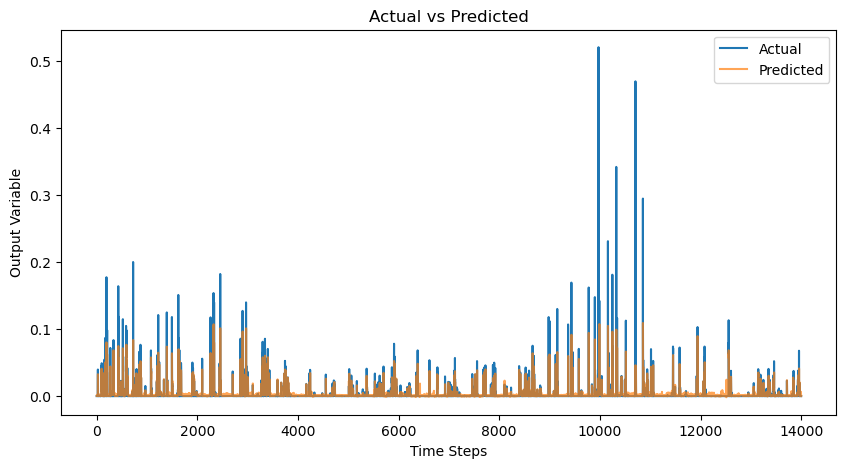

In [9]:
# Plotting results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Output Variable')
plt.legend()
plt.show()

In [11]:
# cross validation, another model

from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

def cross_validate_model(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, test_index in kf.split(X):
        model_clone = clone_model(model)
        model_clone.compile(optimizer='adam', loss='mse')
        
        X_train_kf, X_test_kf = X[train_index], X[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        
        model_clone.fit(X_train_kf, y_train_kf, epochs=10, batch_size=32, verbose=1)
        y_pred_kf = model_clone.predict(X_test_kf)
        mse_kf = mean_squared_error(y_test_kf, y_pred_kf)
        mse_scores.append(mse_kf)
    
    return mse_scores

# Assuming X_train and y_train are already defined and preprocessed
mse_scores = cross_validate_model(X_train, y_train)
print("Cross-validated MSE Scores:", mse_scores)


Epoch 1/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 1.9168e-04
Epoch 2/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.4397e-04
Epoch 3/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.8645e-04
Epoch 4/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 2.6738e-04
Epoch 5/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 1.6444e-04
Epoch 6/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.4190e-04
Epoch 7/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.3544e-04
Epoch 8/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.2648e-04
Epoch 9/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.4053e-04
Epoch 10/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.3505e-04
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Epoch 1/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 1.6871e-04
Epoch 2/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 1.6501e-04
Epoch 3/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - 

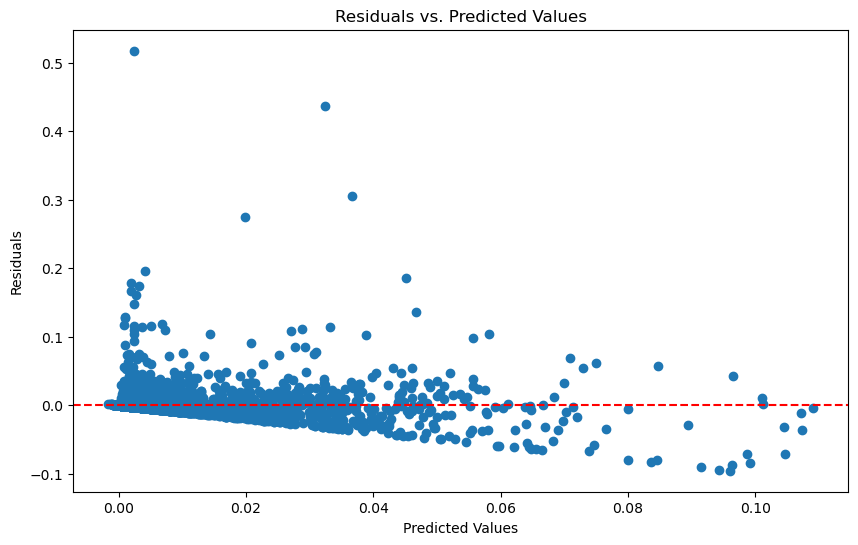

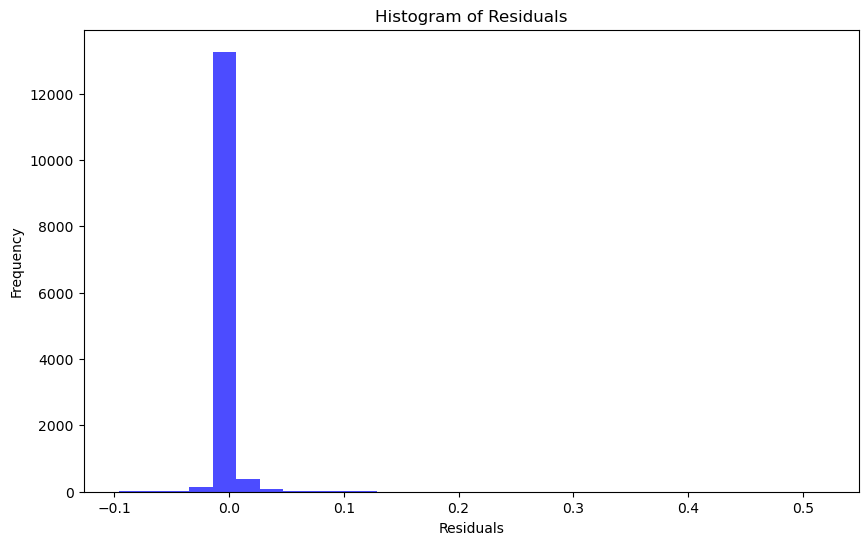

In [10]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Plotting histogram of residuals to check the distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
